In [1]:
import numpy as np 
import tensorflow as tf

In [2]:
from tensorflow.keras import Model, Sequential 
from tensorflow.keras.layers import Conv2D

onehots = np.pad(np.eye(3136).reshape((3136, 56, 56, 1)), ((0,0), (4,4), (4,4), (0,0)), "constant")
onehots = tf.cast(onehots, dtype=tf.float32)

In [3]:
model = Sequential([
    Conv2D(filters = 1, kernel_size = 9, strides = 1, padding = "same" )
])

model.build((None, 64, 64, 1))

image = model(onehots)

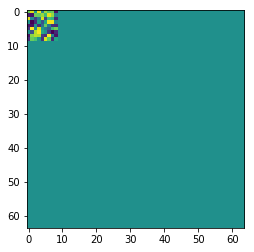

exit


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(image.shape[0]):
    plt.imshow(np.reshape(image[i], (64, 64)))
    plt.show()
    
    if input() == 'exit':
        break

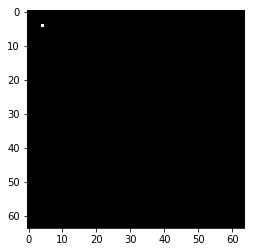

exit


In [5]:
for i in range(onehots.shape[0]):
    plt.imshow(np.reshape(onehots[i], (64, 64)), cmap = 'gray')
    plt.show()
    
    if input() == 'exit':
        break

In [7]:
onehots_coord = np.pad(np.eye(3136).reshape((3136, 56, 56, 1)), ((0,0), (4,4), (4,4), (0,0)), "constant")

def get_coord(inputs, pixel_value):
    assert inputs.dtype == np.float64, "Input should be dtype float64"
    coord_list = []
    for i in range(inputs.shape[0]):
        coord = np.argwhere(inputs[i] == pixel_value)
        coord_list.append(coord)
    return coord_list

def get_coord2(inputs, pixel_value):
    coord_list2 = []
    for i in range(inputs.shape[0]):
        for j in range(inputs.shape[1]):
            for k in range(inputs.shape[2]):             
                if inputs[i, j, k, 0] == pixel_value:
                    xy = [j, k]
                    coord_list2.append(xy)
                                    
    return coord_list2

xy_coord = get_coord(onehots_coord, 1)
#xy_coord2 = get_coord2(onehots, 1)

In [ ]:
# from coord_conv import CoordConv
# from tensorflow.keras import Model, Sequential, layers
# from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Dense
# from tensorflow.keras.layers import Flatten, BatchNormalization, ReLU, LeakyReLU, InputLayer
# import utils

# class Coord_model(Model):
#     def __init__(self):
#         super(Model, self).__init__()
        
#         self.inputlayer = InputLayer(input_shape=(64, 64, 1))
#         self.conv1 = CoordConv(x_dim = 64, y_dim = 64, with_r = False, filters = 64, kernel_size = 3, padding='same', activation='relu')
#         self.flatten = Flatten()
#         self.d1 = Dense(64*64)
#         self.reshape = tf.keras.layers.Reshape((64, 64))
#         self.softmax = tf.keras.layers.Softmax()

#     def call(self, inp):
#         x = inputlayer(inp)
#         x = self.conv1(x)
#         x = self.flatten(x)
#         logits = self.d1(x)
#         logtis = self.reshape(logits)
#         output = self.softmax(logits)

#         return output

# model = Coord_model()

In [ ]:
from coord_conv import CoordConv
from tensorflow.keras import Model, Sequential, layers
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Dense, Reshape, Softmax
from tensorflow.keras.layers import Flatten, BatchNormalization, ReLU, LeakyReLU, InputLayer
import utils

coord_model = Sequential([
    #Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same" ),
    CoordConv(x_dim = 64, y_dim = 64, with_r = False, filters = 64, kernel_size = 3, padding='same', activation='relu'),
    Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same" ),
    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same" ),
    Flatten(),
    Dense(64*64),
    Reshape((64, 64, 1)),
    Softmax(),
])

coord_model.build((None, 64, 64, 1))

In [ ]:
BATCH_SIZE = 32
MAX_STEP = 5000
lr = 1e-4

dataset = zip(image, onehots)

ds_train = tf.data.Dataset.from_tensor_slices((image, onehots)).shuffle(10000).repeat(10).batch(BATCH_SIZE)

In [ ]:
opt = tf.keras.optimizers.Adam(lr)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

train_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.SparseCategoricalAccuracy()


@tf.function
def train_fn(imgs, lbls):
    with tf.GradientTape() as tape:
        output = model(imgs)
        loss = loss_fn(lbls, output)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(lbls, output)


for steps, (img_batch, lbl_batch) in enumerate(ds_train):
    if steps > 5000:
        break

    train_fn(img_batch, lbl_batch)

    Template = 'Step: {}, Loss: {}, Accuracy: {}'

    if not steps % 100:
        print(Template.format(steps, train_loss.result(), train_acc.result()))